# XML: Adding structure to unstructured text

Traditionally, there were two main ways researchers added xml tags to unstructured texts:

1. by manually inserting the tags, often with designated XML editors like OxygenXML.

2. programmatically, often using *regular expression* methods. Regular expressions or regexs, allow you to identify different text components by searching for specific text patterns. For example, you could identify footnotes by searching for text lines that begin with numbers followed by a period and a space found near the bottom of a page. The regex for this would look like this: `"^[0-9]+\.\s\w.*$"` which can be translated as follows:

    + ^ = first character of line
    + [0-9]+ matches any number 0-9 that appears 1 or more times (`+`)
    + \. is followed by a period (which needs to be escaped with a back slash as a period is a special wildcard character in reg ex)
    + \w matches any character or number
    + .* followed by any character (`.`) appearing 0 or more times (`*`) until the end of the line (`$`).

Now, we can use Generative AI tools to do this for us. 

In this notebook, we will import an xml file created from a screenplay script and converted to xml using the GPT-4o Mini model within Dartmouth Chat. 




### Exercise 1. 

Develop your own prompt or revise and improve the prompt below. Then upload your digitized script to chat.dartmouth.edu and run this prompt.

``` 
Here is the full transcript of __________________________
Without adding or changing a single word in this transcript, add xml following TEI guidelines for performance texts. Among other things, this TEI-encoded text should identify different elements of front matter (i.e. <title>, <prologue>, <set>, and <castList> tags), the body text (<div> tags identifying each new scene, <head> tags for the title of each scene, <sp> tags to identify dialogue by each speaker with <speaker> tags tagging each speaker’s name, <l> to identify each line break, <stage> tags to identify stage directions, etc.), and back matter (i.e. <epilogue>). The <sp> tags should identify the name of each speaker, which will help if a particular speaker is implied but not named.

```

## 1. Working with XML text

In [26]:
# %pip install beautifulsoup4
# %pip install lxml

from bs4 import BeautifulSoup
from lxml import etree

In [27]:

with open("../../texts/sopranos-partial.xml", encoding='utf-8') as f:
    txt = f.read()

#

In [28]:
soup = BeautifulSoup(txt, features="xml")

print(soup)

<?xml version="1.0" encoding="utf-8"?>
<TEI xml:lang="en" xmlns="http://www.tei-c.org/ns/1.0" xmlns:hist="http://personal-website-here.com">
<text>
<front>
<title>The Sopranos - Pilot Episode</title>
<set>Locations</set>
<castList>
<castMember>THOMAS SOPRANO</castMember>
<castMember>DR. JENNIFER MELFI</castMember>
<castMember>CARMELA SOPRANO</castMember>
<castMember>MEADOW SOPRANO</castMember>
<castMember>TOMMY JR.</castMember>
<castMember>CHRIS MOLTISANTI</castMember>
<castMember>BIG PUSSY BONPENSIERO</castMember>
<castMember>PAT "PAULIE WALNUTS" GUALTIERI</castMember>
<castMember>DICK BARONE</castMember>
<castMember>ARTIE BUCCO</castMember>
<castMember>CHARMAINE</castMember>
<castMember>LIVIA SOPRANO</castMember>
<castMember>FATHER PHIL</castMember>
<castMember>SILVIO DANTE</castMember>
<castMember>HERMAN "HESH" RABKIN</castMember>
</castList>
</front>
<body>
<div>
<head>INT. DR. MELFI'S WAITING ROOM - DAY</head>
<stage>THOMAS SOPRANO, 40, sits and waits. Uneasily. Staring confusedly

### Extract part of the xml document

In [29]:
# to analyze only the body text of the xml and not the front and back matter:
# extract only the xml found within the first (and only) body tag
body = soup.body

### Extract all incidences of a tag

In [30]:
speeches = body.find_all("sp")
print(len(speeches))
speeches[2]

77


<sp>
<speaker>MELFI</speaker>
<l>My understanding from your family physician, Dr. Cusamano, is you collapsed? Were unable to breathe? Possibly a panic attack?</l>
</sp>

### Create a frequency list of all speakers

In [31]:
from collections import Counter
speakerlist = []
for speech in speeches:
    speakerlist.append(speech.speaker.text)
speakerlist
Counter(speakerlist)

Counter({'TOMMY': 29,
         'MELFI': 16,
         'TOMMY (V.O.)': 7,
         'CARMELA': 6,
         'HUNTER': 5,
         'MEADOW': 4,
         'CHRIS': 4,
         'MAHAFFEY': 3,
         'MELFI (V.O.)': 2,
         'KIDS': 1})

### Create a dataframe containing the dialogue of the screenplay, organized by speaker and the order in which the speech was made.

In [32]:
import copy

speechlist2 = []
for speech in speeches:
    speechcopy = copy.copy(speech)
    for speaker_tag in speechcopy.find_all("speaker"):
        speaker_tag.decompose()
    #print(speechcopy, "\n$$")
    #print(speech)
    #print()
    speechlist2.append(speechcopy)

# remove speaker tag
speechlist2 = [speech.text.strip() for speech in speechlist2]
speechlist2

['Mr. Soprano?',
 'Have a seat.',
 'My understanding from your family physician, Dr. Cusamano, is you collapsed? Were unable to breathe? Possibly a panic attack?',
 'They said it was a panic attack — because all the neurological work and blood came back negative. They sent me here.',
 "You don't agree you had a panic attack?",
 'How are you feeling now?',
 "Now? Fine. I'm back at work.",
 'What line of work are you in?',
 'Waste management consultant.',
 "Look...it's impossible for me to talk to a psychiatrist.",
 'Any thoughts at all on why you blacked out?',
 "I don't know. Stress/ maybe?",
 'Stress? About what?',
 "That morning of the day I got sick? I'd been thinking: it's good to be in a thing from the ground floor. I came too late for that, I know. But lately I'm getting the feeling I might be in at the end. That the best is over.",
 'Many Americans, I think, feel this.',
 'Take my father. He never reached the heights like me. But in ways he had it better. He had his people — the

In [33]:
import pandas as pd

df = pd.DataFrame({"speaker": speakerlist, "speech": speechlist2})

df

,speaker,speech
0,MELFI,Mr. Soprano?
1,MELFI,Have a seat.
2,MELFI,"My understanding from your family physician, D..."
3,TOMMY,They said it was a panic attack — because all ...
4,MELFI,You don't agree you had a panic attack?
...,...,...
72,TOMMY,I'll give you a fuckin' bone. Where's my money?
73,MAHAFFEY,I'll get the money!
74,TOMMY,I know you'll get the — (sees Chris fussing ov...
75,TOMMY,The fuck you doing? Get over here.


### Count the number of times each character spoke

In [34]:
df["speaker"].value_counts()

speaker
TOMMY           29
MELFI           16
TOMMY (V.O.)     7
CARMELA          6
HUNTER           5
MEADOW           4
CHRIS            4
MAHAFFEY         3
MELFI (V.O.)     2
KIDS             1
Name: count, dtype: int64

vs. GPT-4o Mini response:

```

Here is the frequency list of the number of times each character spoke, derived from the screenplay: 

    TOMMY: 20
    MELFI: 10
    CARMELA: 7
    CHRIS: 6
    HUNTER: 4
    MAHAFFEY: 4
    MEADOW: 4
    BIG PUSSY: 3
    DAD (TOMMY SR.): 3
    ARTHUR: 2
    LIVIA: 2
    FATHER PHIL: 2
    SILVIO: 2
    TOMMY JR.: 2
    DICK BARONE: 1
    CHARMAINE: 1
    HERMAN: 1
     

This list counts each individual line spoken by the characters in the screenplay as a separate instance. 
```


## Most Frequent Words (by Speaker)

### Python + spaCY v. GPT-4

Group speech by speaker.

In [35]:
# Group by 'speaker' and concatenate speeches
grouped_df = df.groupby('speaker')['speech'].agg(lambda x: ' '.join(x)).reset_index()

# Rename the 'speech' column if desired
grouped_df.rename(columns={'speech': 'combined_speech'}, inplace=True)

grouped_df

,speaker,combined_speech
0,CARMELA,Have something more than just cran- apple juic...
1,CHRIS,I got home too late last night. I didn't want ...
2,HUNTER,"(staring out window) Meadow, your father with ..."
3,KIDS,"(bored, humoring) Nice, dad. National Geograph..."
4,MAHAFFEY,"Security! My leg! It's broken! Oh fuck, oh fuc..."
5,MEADOW,Get out of here with that fat. Wait — like Ita...
6,MELFI,Mr. Soprano? Have a seat. My understanding fro...
7,MELFI (V.O.),"Many Americans, I think, feel this. Did you ha..."
8,TOMMY,They said it was a panic attack — because all ...
9,TOMMY (V.O.),That morning of the day I got sick? I'd been t...


In [36]:
import spacy
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
nlp = spacy.load("en_core_web_sm")

# Function to preprocess the text
def lemmatize_text(text):
    lemmatized_words = []

    # Process each text element in the list
    #for text in text_list:
        # Process the text with spaCy
    doc = nlp(text)
        
    # Lemmatize words and filter out stop words
    for token in doc:
        # Check if the token is a stop word or punctuation
        if not token.is_stop and token.is_alpha:
            lemmatized_words.append(token.lemma_.lower())

    return lemmatized_words

# Function to find the top N frequent words
def top_n_frequent_words(word_list, n=5):
    # Count the frequency of each word
    word_counts = Counter(word_list)
    
    # Get the N most common words
    return word_counts.most_common(n)

In [37]:
grouped_df["lemmas"] = grouped_df["combined_speech"].apply(lemmatize_text)
grouped_df["top_words"] = grouped_df["lemmas"].apply(top_n_frequent_words, n=5)
grouped_df


,speaker,combined_speech,lemmas,top_words
0,CARMELA,Have something more than just cran- apple juic...,"[apple, juice, lady, need, brain, food, school...","[(school, 2), (apple, 1), (juice, 1), (lady, 1..."
1,CHRIS,I got home too late last night. I didn't want ...,"[get, home, late, night, want, wake, man, naus...","[(boo, 2), (get, 1), (home, 1), (late, 1), (ni..."
2,HUNTER,"(staring out window) Meadow, your father with ...","[stare, window, meadow, father, duck, male, fe...","[(duck, 2), (aspen, 2), (stare, 1), (window, 1..."
3,KIDS,"(bored, humoring) Nice, dad. National Geograph...","[bored, humor, nice, dad, national, geographic...","[(bored, 1), (humor, 1), (nice, 1), (dad, 1), ..."
4,MAHAFFEY,"Security! My leg! It's broken! Oh fuck, oh fuc...","[security, leg, break, oh, fuck, oh, fuck, bon...","[(oh, 2), (fuck, 2), (security, 1), (leg, 1), ..."
5,MEADOW,Get out of here with that fat. Wait — like Ita...,"[fat, wait, like, italian, pastry, brain, food...","[(fat, 1), (wait, 1), (like, 1), (italian, 1),..."
6,MELFI,Mr. Soprano? Have a seat. My understanding fro...,"[soprano, seat, understanding, family, physici...","[(say, 4), (tell, 3), (family, 2), (physician,..."
7,MELFI (V.O.),"Many Americans, I think, feel this. Did you ha...","[americans, think, feel, feeling, loss, acutel...","[(americans, 1), (think, 1), (feel, 1), (feeli..."
8,TOMMY,They said it was a panic attack — because all ...,"[say, panic, attack, neurological, work, blood...","[(work, 4), (know, 3), (beat, 3), (fuckin, 3),..."
9,TOMMY (V.O.),That morning of the day I got sick? I'd been t...,"[morning, day, get, sick, think, good, thing, ...","[(get, 2), (good, 2), (know, 2), (daughter, 2)..."


Top 5 word frequency list as generated by GPT-4o Mini:

*Prompt:*
```
Create a frequency list of words to aid the analysis of this screenplay. First, extract only the spoken text, indicated by the <l> tag within each <sp> tag. Second, from this spoken text, create a frequency list of the top 5 words spoken by each speaker, but only after removing all stop words.
```

*Response:*


GPT-4o Mini (Cloud, Paid, $) 2024-07-18
Today at 4:15 PM
 

Here's the frequency list of the top 5 words spoken by each character, after removing stop words: 

**TOMMY** 

    money: 5
    ducks: 3
    work: 3
    father: 3
    feel: 3
     

**MELFI** 

    panic: 3
    understanding: 2
    attack: 2
    work: 2
    stress: 2
     

**CARMELA** 

    Meadow: 4
    school: 3
    grades: 2
    father: 2
    ziti: 2
     

**CHRIS** 

    Mahaffey: 3
    business: 3
    money: 3
    call: 2
    family: 2
     

**HUNTER** 

    Aspen: 2
    cool: 2
    think: 2
    fun: 2
    vacation: 2
     

**MAHAFFEY** 

    sorry: 3
    money: 3
    broken: 2
    leg: 2
    company: 2
     

**MEADOW** 

    dad: 3
    think: 2
    stupid: 2
    school: 2
    trip: 2
     

**BIG PUSSY** 

    business: 2
    Kolar: 2
    money: 2
    good: 2
    family: 2
     

**ARTHUR** 

    help: 2
    vacation: 2
    deal: 2
    restaurant: 2
    days: 2
     

**LIVIA** 

    home: 2
    nursing: 2
    mother: 2
    day: 2
    people: 2
     

**FATHER PHIL** 

    damn: 2
    night: 2
    incredible: 2
    just: 2
    think: 2
     

**SILVIO** 

    night: 2
    family: 2
    go: 2
    talk: 2
    people: 2
     

**TOMMY JR.** 

    grandma: 2
    happy: 2
    home: 2
    dad: 2
    birthday: 2
     

**DICK BARONE** 

    contract: 1
    money: 1
    business: 1
    call: 1
    good: 1
     

**CHARMAINE** 

    gift: 1
    stay: 1
    home: 1
    better: 1
    anything: 1
     

**HERMAN** 

    chance: 1
    money: 1
    problem: 1
    time: 1
    feelings: 1
     

This frequency list highlights the common words spoken by each character, providing insights into their dialogue patterns and focal points in the screenplay. 

## Extracting Information for each Scene

In [45]:
def get_scene_info(tag):
    """
    Reads in a bs4 "div tag" containing a scene in a screenplay (using the tags: head = name of scene; stage = stage directions, speaker = for the name of each speaker)

    Returns a dictionary containing the scene name, initial stage instructions (ignores any 2nd or 3rd stage instructions), and speaker count for each scene
    """
    if tag.name != "div":
        print("error, not a div tag!")
        return None, None, None
    head = tag.find("head")
    if head is not None:
        head = head.text
    stage = tag.find("stage")
    if stage is not None:
        stage = stage.text

    speakerlist = []
    if tag.find("speaker"):
        speakers = tag.find_all("speaker")
        speakerlist = [speaker.text for speaker in speakers]
    speakerlist

    speaker_ct = Counter(speakerlist)

    return {"head": head, "stage": stage, "speaker_ct": speaker_ct, "speaker": speakerlist}


In [ ]:
divs = body.find_all("div")

sceneinfodict_list = []

for div in divs:
    sceneinfodict_list.append(get_scene_info(div))

scene_df = pd.DataFrame(sceneinfodict_list)


,head,stage,speaker_ct,speaker
0,INT. DR. MELFI'S WAITING ROOM - DAY,"THOMAS SOPRANO, 40, sits and waits. Uneasily. ...",{'MELFI': 1},[MELFI]
1,INT. DR. MELFI'S OFFICE - DAY,Melfi gestures Tommy to a choice of seating.,"{'MELFI': 7, 'TOMMY': 5}","[MELFI, MELFI, TOMMY, MELFI, MELFI, TOMMY, MEL..."
2,EXT. SOPRANO HOUSE - DAWN,split-level. New Jersey. The only thing distin...,{},[]
3,INT. SOPRANO HOUSE - BEDROOM - DAWN,TOMMY'S EYE slams open from sleep. He stares s...,{'TOMMY (V.O.)': 1},[TOMMY (V.O.)]
4,EXT. SOPRANO HOUSE - DAY,Bathrobed Tommy reads his morning paper in the...,"{'MELFI (V.O.)': 2, 'TOMMY (V.O.)': 1}","[MELFI (V.O.), TOMMY (V.O.), MELFI (V.O.)]"


In [41]:
len(scene_df)

19

In [56]:
scene_df["scene_num"] = scene_df.index
scene_df.head()

,head,stage,speaker_ct,speaker,scene_num
0,INT. DR. MELFI'S WAITING ROOM - DAY,"THOMAS SOPRANO, 40, sits and waits. Uneasily. ...",{'MELFI': 1},[MELFI],0
1,INT. DR. MELFI'S OFFICE - DAY,Melfi gestures Tommy to a choice of seating.,"{'MELFI': 7, 'TOMMY': 5}","[MELFI, MELFI, TOMMY, MELFI, MELFI, TOMMY, MEL...",1
2,EXT. SOPRANO HOUSE - DAWN,split-level. New Jersey. The only thing distin...,{},[],2
3,INT. SOPRANO HOUSE - BEDROOM - DAWN,TOMMY'S EYE slams open from sleep. He stares s...,{'TOMMY (V.O.)': 1},[TOMMY (V.O.)],3
4,EXT. SOPRANO HOUSE - DAY,Bathrobed Tommy reads his morning paper in the...,"{'MELFI (V.O.)': 2, 'TOMMY (V.O.)': 1}","[MELFI (V.O.), TOMMY (V.O.), MELFI (V.O.)]",4


In [69]:
# Explode the 'speaker' column
exploded_df = scene_df.explode('speaker')
exploded_df.tail(10)

,head,stage,speaker_ct,speaker,scene_num
16,INT. DR. MELFI'S OFFICE - DAY,He waits. She smiles nervously.,"{'TOMMY': 11, 'MELFI': 6, 'MAHAFFEY': 3}",TOMMY,16
16,INT. DR. MELFI'S OFFICE - DAY,He waits. She smiles nervously.,"{'TOMMY': 11, 'MELFI': 6, 'MAHAFFEY': 3}",TOMMY,16
16,INT. DR. MELFI'S OFFICE - DAY,He waits. She smiles nervously.,"{'TOMMY': 11, 'MELFI': 6, 'MAHAFFEY': 3}",TOMMY,16
17,EXT. STREET - BUSINESS DISTRICT - US/HMQ - DAY,"When Mahaffey sees Tommy, his latte spatters t...",{'MAHAFFEY': 1},MAHAFFEY,17
18,EXT. PARKING LOT - DAY,Tommy suddenly draws abreast of Chris in the L...,"{'MAHAFFEY': 2, 'TOMMY': 4}",MAHAFFEY,18
18,EXT. PARKING LOT - DAY,Tommy suddenly draws abreast of Chris in the L...,"{'MAHAFFEY': 2, 'TOMMY': 4}",TOMMY,18
18,EXT. PARKING LOT - DAY,Tommy suddenly draws abreast of Chris in the L...,"{'MAHAFFEY': 2, 'TOMMY': 4}",MAHAFFEY,18
18,EXT. PARKING LOT - DAY,Tommy suddenly draws abreast of Chris in the L...,"{'MAHAFFEY': 2, 'TOMMY': 4}",TOMMY,18
18,EXT. PARKING LOT - DAY,Tommy suddenly draws abreast of Chris in the L...,"{'MAHAFFEY': 2, 'TOMMY': 4}",TOMMY,18
18,EXT. PARKING LOT - DAY,Tommy suddenly draws abreast of Chris in the L...,"{'MAHAFFEY': 2, 'TOMMY': 4}",TOMMY,18


In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a unique y position for each speaker based on their first appearance
combined_speakerlist = [item for sublist in scene_df['speaker'] for item in sublist]
combined_speakerlist


['MELFI',
 'MELFI',
 'MELFI',
 'TOMMY',
 'MELFI',
 'MELFI',
 'TOMMY',
 'MELFI',
 'TOMMY',
 'TOMMY',
 'MELFI',
 'TOMMY',
 'MELFI',
 'TOMMY (V.O.)',
 'MELFI (V.O.)',
 'TOMMY (V.O.)',
 'MELFI (V.O.)',
 'TOMMY (V.O.)',
 'TOMMY',
 'TOMMY (V.O.)',
 'HUNTER',
 'CARMELA',
 'HUNTER',
 'CARMELA',
 'MEADOW',
 'CARMELA',
 'MEADOW',
 'HUNTER',
 'HUNTER',
 'TOMMY',
 'TOMMY',
 'TOMMY',
 'KIDS',
 'HUNTER',
 'MEADOW',
 'TOMMY',
 'CARMELA',
 'MEADOW',
 'TOMMY',
 'CARMELA',
 'TOMMY',
 'CARMELA',
 'TOMMY',
 'MELFI',
 'TOMMY',
 'MELFI',
 'TOMMY (V.O.)',
 'TOMMY (V.O.)',
 'TOMMY',
 'CHRIS',
 'TOMMY',
 'CHRIS',
 'TOMMY (V.O.)',
 'CHRIS',
 'TOMMY',
 'CHRIS',
 'TOMMY',
 'TOMMY',
 'MELFI',
 'TOMMY',
 'MELFI',
 'MELFI',
 'TOMMY',
 'MELFI',
 'TOMMY',
 'MELFI',
 'TOMMY',
 'MELFI',
 'TOMMY',
 'TOMMY',
 'MAHAFFEY',
 'MAHAFFEY',
 'TOMMY',
 'MAHAFFEY',
 'TOMMY',
 'TOMMY',
 'TOMMY',
 'MAHAFFEY',
 'MAHAFFEY',
 'TOMMY',
 'MAHAFFEY',
 'TOMMY',
 'TOMMY',
 'TOMMY']

In [73]:
#speaker_order = {speaker: i for i, speaker in enumerate(set(combined_speakerlist))}
#
speaker_order = {speaker: i for i, speaker in enumerate(exploded_df.loc[exploded_df["speaker"].notna(), 'speaker'].unique())}

"""
speaker_order = {speaker: i for i, speaker in enumerate(set(combined_speakerlist))}
speaker_order = {}
spkr_ct = 0
for speaker in combined_speakerlist:
    if speaker not in speaker_order.keys():
        speaker_order[speaker] = spkr_ct
        spkr_ct += 1
speaker_order
"""

speaker_order

{'MELFI': 0,
 'TOMMY': 1,
 'TOMMY (V.O.)': 2,
 'MELFI (V.O.)': 3,
 'HUNTER': 4,
 'CARMELA': 5,
 'MEADOW': 6,
 'KIDS': 7,
 'CHRIS': 8,
 'MAHAFFEY': 9}

In [74]:
exploded_df['y_position'] = exploded_df['speaker'].map(speaker_order)
exploded_df.head()

,head,stage,speaker_ct,speaker,scene_num,y_position
0,INT. DR. MELFI'S WAITING ROOM - DAY,"THOMAS SOPRANO, 40, sits and waits. Uneasily. ...",{'MELFI': 1},MELFI,0,0.0
1,INT. DR. MELFI'S OFFICE - DAY,Melfi gestures Tommy to a choice of seating.,"{'MELFI': 7, 'TOMMY': 5}",MELFI,1,0.0
1,INT. DR. MELFI'S OFFICE - DAY,Melfi gestures Tommy to a choice of seating.,"{'MELFI': 7, 'TOMMY': 5}",MELFI,1,0.0
1,INT. DR. MELFI'S OFFICE - DAY,Melfi gestures Tommy to a choice of seating.,"{'MELFI': 7, 'TOMMY': 5}",TOMMY,1,1.0
1,INT. DR. MELFI'S OFFICE - DAY,Melfi gestures Tommy to a choice of seating.,"{'MELFI': 7, 'TOMMY': 5}",MELFI,1,0.0


In [80]:
# remove subsequent appearances of characters in a scene
scene_spkr_df = exploded_df.groupby(["scene_num", "speaker"]).first().reset_index()

scene_spkr_df.head()



,scene_num,speaker,head,stage,speaker_ct,y_position
0,0,MELFI,INT. DR. MELFI'S WAITING ROOM - DAY,"THOMAS SOPRANO, 40, sits and waits. Uneasily. ...",{'MELFI': 1},0.0
1,1,MELFI,INT. DR. MELFI'S OFFICE - DAY,Melfi gestures Tommy to a choice of seating.,"{'MELFI': 7, 'TOMMY': 5}",0.0
2,1,TOMMY,INT. DR. MELFI'S OFFICE - DAY,Melfi gestures Tommy to a choice of seating.,"{'MELFI': 7, 'TOMMY': 5}",1.0
3,3,TOMMY (V.O.),INT. SOPRANO HOUSE - BEDROOM - DAWN,TOMMY'S EYE slams open from sleep. He stares s...,{'TOMMY (V.O.)': 1},2.0
4,4,MELFI (V.O.),EXT. SOPRANO HOUSE - DAY,Bathrobed Tommy reads his morning paper in the...,"{'MELFI (V.O.)': 2, 'TOMMY (V.O.)': 1}",3.0


In [90]:
def return_speaker_ct(row):
    if row["speaker"] in row["speaker_ct"]:
        return row["speaker_ct"][row["speaker"]]
    else:
        return 0
    
scene_spkr_df["count"]  = scene_spkr_df.apply(return_speaker_ct, axis=1)
scene_spkr_df.head()

,scene_num,speaker,head,stage,speaker_ct,y_position,count
0,0,MELFI,INT. DR. MELFI'S WAITING ROOM - DAY,"THOMAS SOPRANO, 40, sits and waits. Uneasily. ...",{'MELFI': 1},0.0,1
1,1,MELFI,INT. DR. MELFI'S OFFICE - DAY,Melfi gestures Tommy to a choice of seating.,"{'MELFI': 7, 'TOMMY': 5}",0.0,7
2,1,TOMMY,INT. DR. MELFI'S OFFICE - DAY,Melfi gestures Tommy to a choice of seating.,"{'MELFI': 7, 'TOMMY': 5}",1.0,5
3,3,TOMMY (V.O.),INT. SOPRANO HOUSE - BEDROOM - DAWN,TOMMY'S EYE slams open from sleep. He stares s...,{'TOMMY (V.O.)': 1},2.0,1
4,4,MELFI (V.O.),EXT. SOPRANO HOUSE - DAY,Bathrobed Tommy reads his morning paper in the...,"{'MELFI (V.O.)': 2, 'TOMMY (V.O.)': 1}",3.0,2


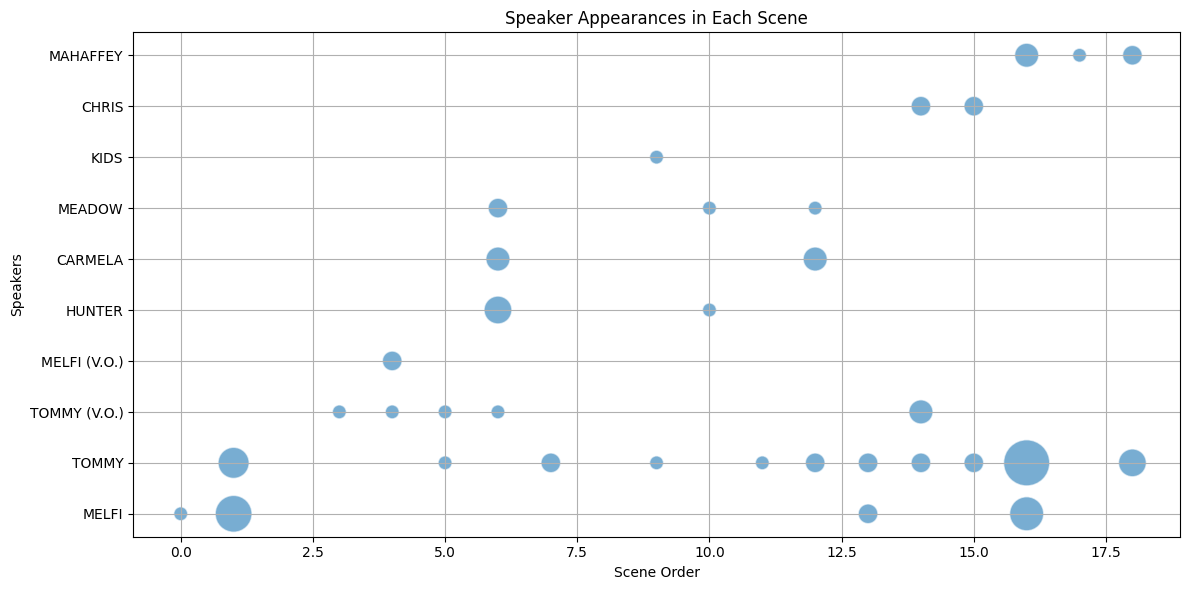

In [92]:
# Create the plot
plt.figure(figsize=(12, 6))

# Create a scatter plot
scatter = plt.scatter(scene_spkr_df['scene_num'], scene_spkr_df['y_position'], 
                      s=scene_spkr_df['count'] * 100,  # Size by speaker count for better visibility
                      alpha=0.6,
                      edgecolors='w')

# Set y-ticks to show speaker names
plt.yticks(list(speaker_order.values()), list(speaker_order.keys()))

# Set labels and title
plt.xlabel('Scene Order')
plt.ylabel('Speakers')
plt.title('Speaker Appearances in Each Scene')

# Show the grid
plt.grid()

# Show the plot
plt.tight_layout()
plt.show()

In [96]:
from joypy import joyplot

# Pivot the DataFrame
pivot_df = scene_spkr_df.pivot(index='scene_num', columns='speaker', values='count').fillna(0)
speaker_counts = [pivot_df[speaker].values for speaker in pivot_df.columns]

# Create the ridgeline plot
plt.figure(figsize=(12, 6))

# Call the joyplot function
joyplot(speaker_counts,
        #pivot_df.values, 
        labels=pivot_df.columns, 
        overlap=0.5, # Overlap between ridgelines 
        fade=True,    # Fade effect
        linewidth=1,  # Line width
        figsize=(12, 6))

# Set labels
plt.title('Speaker Frequency in Each Scene (Ridgeline Plot)')
plt.xlabel('Number of Times They Speak')
plt.ylabel('Speakers')
plt.yticks(range(len(pivot_df.columns)), pivot_df.columns)

# Show the plot
plt.tight_layout()
plt.show()

ValueError: The truth value of a Index is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

<Figure size 1200x600 with 0 Axes>

In [101]:
len(pivot_df.columns)

10

In [94]:
pivot_df.values

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  7.,  0.,  5.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.],
       [ 3.,  0.,  4.,  0.,  0.,  2.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
       [ 3.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  2.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  2.,  0.],
       [ 0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  3.],
       [ 0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.],
       [ 0.,  0.,  0.,  0.,  3.,  0.,  6.,  0., 11.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  4.,  0.